Notebook visualizes a point cloud from a RGBD Image using the open3d library

Step1: Import neccesary libraries

In [78]:
import numpy as np
from src.visualisation.observation_visualisation import display_sample
from src.config import default_sim_cfg
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

Step2: Read and compute camera intrinsics

In [ ]:
#import camera intrinsics
sim_cfg = default_sim_cfg()

#Reading and computing camera intrinsic parameters
w,h = sim_cfg.WIDTH,sim_cfg.HEIGHT #img width and height in px
cx,cy = w/2,h/2 #point of origin in x and y dimension
hfov = 90 #horizontal field of view in degrees of pinhole camera model
hfov = float(hfov) * np.pi / 180. #transformation of the hfov-degrees
f = (cx/2)/np.tan(hfov/2) #focal length in mm


Step 3: Select and display a RGBD image from one of the trajectories

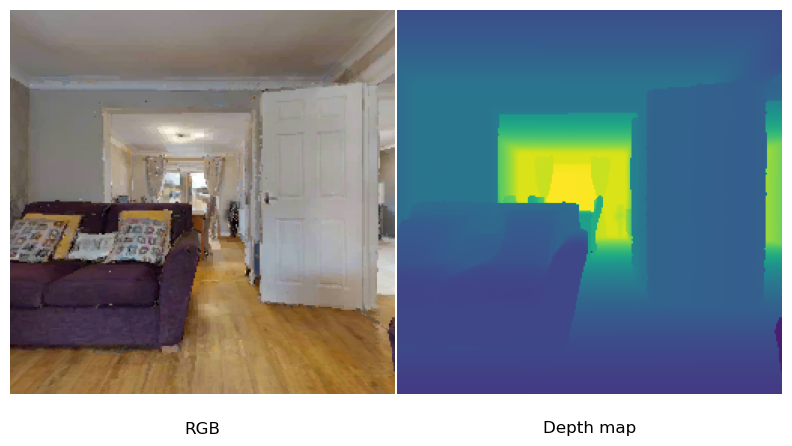

In [90]:
#Select image number 205 from first trajectory to test 3D mapping
#RGB Image
rgb = cv2.imread('/workspaces/ReSEAL/data/interim/trajectories/train/00000-kfPV7w3FaU5/RGB/205.png')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
#Depth Map
d = np.load('/workspaces/ReSEAL/data/interim/trajectories/train/00000-kfPV7w3FaU5/D/205.npy')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0)

# Turn off axis labels and ticks for both subplots
for ax in axes:
    ax.set_axis_off()

# Show the images in the subplots
axes[0].imshow(rgb)
axes[0].text(0.5, -0.1, 'RGB', size=12, ha="center", transform=axes[0].transAxes)
axes[1].imshow(d)
axes[1].text(0.5, -0.1, 'Depth map', size=12, ha="center", transform=axes[1].transAxes)
# Show the plot
plt.show()


Step4: Convert that image into a 3D point cloud

In [96]:
# Create RGBDImage object
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(rgb),
    o3d.geometry.Image(d),
    convert_rgb_to_intensity=False
)

# Create PointCloud object from RGBD image
intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=f, fy=f, cx=cx, cy=cy)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)

# Visualize the point cloud
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd]) #displays point cloud



Step5: Extract 3D coodinates from the point cloud

In [ ]:
#Extract the 3D coordinates for each pixel
coordinates = np.asarray(pcd.points)
coordinates.shape
